In [3]:
# User input, generate depth profile of which terrain type

terrainTypes =['Till', 'Organics', 'Valley', 'Eskers']
terrainType = 'Till'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MeanShift, estimate_bandwidth
import umap.umap_ as umap
from itertools import cycle
from functools import partial
from scipy import stats
from collections import Counter

In [5]:
bh_file_path = 'Lac_de_Gras_borehole_only.csv'
df = pd.read_csv(bh_file_path, header=[0])
len(df)

224

In [6]:
df = df.dropna(subset=['UnitCode'])

In [7]:
df.Frozen = df.Frozen.str.split(pat=',').str[0]
df.Frozen = df.Frozen.eq('Yes').mul(1)

In [8]:
df.UnitCode = df.UnitCode.str.split(pat=',').str[0]
df['UnitCode'].replace(['Till '], 'Till', regex=True, inplace=True)
materials = df.UnitCode.unique()
materials

array(['Till', 'Organics', 'Boulder', 'Ice', 'Clay', 'Gravel/Cobbles',
       'Soil', 'Sand', 'Silt'], dtype=object)

In [9]:
parameters = ['ExIceCont_perc', 'GWCWetBase_perc', 'Frozen', 'Gravel_perc', 'Sand_perc', 'Fines_perc']
# parameters = ['ExIceCont_perc', 'GWCWetBase_perc', 'Frozen']

In [10]:

df_tt = df.loc[df['TerrainType'] == terrainType]
df_tt = df_tt.dropna(subset=parameters)
print(f'There are {len(df_tt)} samples in terrain type {terrainType}')

There are 83 samples in terrain type Till


In [11]:
depths = df_tt['SampleDepth'].to_numpy(dtype='float')
# df_tt = df_tt[parameters]

In [12]:
np_tt = df_tt[parameters].to_numpy(dtype='float')
scaler = StandardScaler()
scaler.fit(np_tt)
np_tt_scaled = scaler.transform(np_tt)
np_tt_scaled.shape

(83, 6)

In [13]:
np_tt

array([[ 0.  ,  5.19,  0.  ,  5.  , 90.  ,  5.  ],
       [ 0.  ,  6.15,  0.  ,  5.  , 90.  ,  5.  ],
       [ 0.  ,  9.6 ,  0.  , 10.  , 80.  , 10.  ],
       [ 0.  ,  9.32,  0.  , 25.  , 65.  , 10.  ],
       [ 0.  , 25.92,  0.  , 10.  , 80.  , 10.  ],
       [ 0.  ,  6.28,  0.  , 25.  , 65.  , 10.  ],
       [ 0.  , 12.87,  0.  , 10.  , 85.  ,  5.  ],
       [ 0.  ,  7.66,  0.  , 20.  , 70.  , 10.  ],
       [ 0.  , 13.07,  0.  ,  5.  , 90.  ,  5.  ],
       [ 0.  ,  4.09,  0.  , 60.  , 35.  ,  5.  ],
       [ 0.  ,  6.69,  0.  , 25.  , 65.  , 10.  ],
       [33.19, 52.27,  1.  ,  0.  , 35.  , 65.  ],
       [24.21, 40.85,  1.  , 30.  , 60.  , 10.  ],
       [21.72, 32.98,  1.  , 15.  , 70.  , 15.  ],
       [36.3 , 49.74,  1.  , 10.  , 70.  , 20.  ],
       [14.79, 18.33,  1.  , 10.  , 70.  , 20.  ],
       [17.08, 48.97,  1.  , 15.  , 75.  , 10.  ],
       [43.27, 61.79,  1.  ,  5.  , 30.  , 65.  ],
       [ 0.  ,  5.24,  1.  , 25.  , 65.  , 10.  ],
       [ 0.  ,  8.13,  1.  , 25

## Clustering

In [14]:
bandwidth = estimate_bandwidth(np_tt_scaled, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(np_tt_scaled)
labels = ms.labels_
#labels looks like [0, 0, 0, 1, 1, 1, 1, 2, 2,....]

cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 5


In [15]:
reducer = umap.UMAP()

In [16]:
embedding = reducer.fit_transform(np_tt_scaled)
embedding.shape

(83, 2)

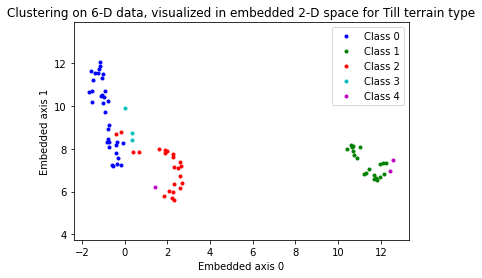

In [20]:
plt.clf()
# fig = plt.figure()
# ax = plt.axes(projection='3d')

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(embedding[my_members, 0], embedding[my_members, 1], col + ".")
    # plt.scatter(np_tt_scaled[my_members, 0], np_tt_scaled[my_members, 1], np_tt_scaled[my_members, 2], c=col)
    
plt.title("Clustering on 6-D data, visualized in embedded 2-D space for {} terrain type".format(terrainType)) # Estimated number of clusters: %d" % n_clusters_
plt.xlabel("Embedded axis 0")
plt.ylabel("Embedded axis 1")
plt.axis('equal')
plt.legend(["Class 0", "Class 1", "Class 2","Class 3", "Class 4"])
plt.show()

## Logistic Regression Classificiation

In [ ]:
logreg = LogisticRegression()
logreg.fit(depths.reshape(-1, 1), labels)

In [ ]:
depths_syn = np.arange(np.floor(depths.min()),np.ceil(depths.max()),0.5)
depths_syn_fine = np.arange(np.floor(depths.min()),np.ceil(depths.max()),0.1)
profile = logreg.predict(depths_syn.reshape(-1,1))
profile_fine = logreg.predict(depths_syn_fine.reshape(-1,1))

In [ ]:
ind_change = np.where(profile_fine[:-1] != profile_fine[1:])[0]+1

In [ ]:
ind_change = np.insert(ind_change, 0, 0)
ind_change = np.append(ind_change, len(profile_fine))

In [ ]:
plt.imshow(profile.reshape(-1,1))

In [ ]:
profile_samples = logreg.predict(depths.reshape(-1,1))

In [ ]:
logreg.classes_

In [ ]:
np.unique(profile_samples)

In [ ]:
n_rows = len(ind_change)-1
n_cols = len(parameters) * 5 + 3 + len(materials)
arr = np.zeros([n_rows, n_cols])

In [ ]:
n_params= len(parameters)

In [ ]:
def material_percentage(current_material, cl_materials):
    n_current_material = sum(cl_materials==current_material)
    return float(n_current_material) / len(cl_materials)

In [ ]:
for i in range(len(ind_change)-1):
    ind = ind_change[i]
    ind_next = ind_change[i+1]
    
    cl = profile_fine[ind]
    begin = depths_syn_fine[ind]
    end = depths_syn_fine[ind_next-1]

    arr[i, 0] = cl
    arr[i, 1] = begin
    arr[i, 2] = end

    cl_ind = profile_samples==cl

    cl_materials = df_tt.iloc[cl_ind].UnitCode

    n_materials = len(materials)
    arr[i, 3: 3+n_materials] = [float(sum(cl_materials==current_material)) / len(cl_materials) for current_material in materials]
    
    np_class = np_tt[cl_ind]
    mean_arr = np.mean(np_class, axis=0)
    min_arr = np.min(np_class, axis=0)
    max_arr = np.max(np_class, axis=0)
    mode_arr = 3*mean_arr - max_arr - min_arr

    print(np_class)
    print(mean_arr)
    print(min_arr)
    print(max_arr)
    print(mode_arr)
    values = np.concatenate([mean_arr, 
                             np.std(np_class, axis=0), 
                             min_arr, 
                             max_arr, 
                             mode_arr])

    arr[i, 3 + n_materials:] = values
    
    #print(df_class.std())

In [ ]:
np.squeeze(stats.mode(np_class, axis=0).mode).shape

In [ ]:
np.squeeze(stats.mode(np_class, axis=0).mode)

In [ ]:
column_values = ['layerClass', 'depthBegin', 'depthEnd']

In [ ]:
mean_columns = [s + '_Mean' for s in parameters]
std_columns = [s + '_Std' for s in parameters]
materials_perc = [s + "_perc" for s in materials]

min_col = [s + '_min' for s in parameters]
max_col = [s + '_max' for s in parameters]
mode_col = [s + '_mode' for s in parameters]

column_values = column_values + materials_perc + mean_columns + std_columns + min_col + max_col + mode_col

In [ ]:
df_tt_summary = pd.DataFrame(data = arr, columns = column_values)

In [ ]:
df_tt_summary.to_csv('profile_' + terrainType+'_Summary.csv')